<div align="center">
  <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" width="70%" style="min-width: 300px; max-width: 600px;">
  <h1>INF396 - Introducción a la Ciencia de Datos</h1>
  <h3 style="color: #555;">Tarea #2</h3>
  <p>
    <strong>Alessandro Bruno Cintolesi Rodriguez</strong><br>
    <em>202173541-0</em><br>
    <em>alessandro.cintolesi@usm.cl</em>
  </p>
</div>

<hr>

In [27]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skimpy import skim
from statsmodels.graphics.tsaplots import plot_acf

In [48]:
def kfold_cv(pipeline, x, y, n_splits=10):
	kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
	mse_list = []

	for train_index, test_index in kf.split(x):
		x_train, x_test = x[train_index], x[test_index]
		y_train, y_test = y[train_index], y[test_index]

		pipeline.fit(x_train, y_train)
		y_pred = pipeline.predict(x_test)

		mse = mean_squared_error(y_test, y_pred)
		mse_list.append(mse)

	w = pipeline.named_steps['Model'].coef_
	b = pipeline.named_steps['Model'].intercept_

	avg_mse = np.mean(mse_list)
	print(f"Mean MSE (KFold) = {avg_mse:.10f}, Weigths (w) = {w}, Bias (b) = {b}")

In [3]:
def generate_plot_acf(x, title, lags=40, markersize=6):
	size = round(x.shape[0]*0.1)
	temp = x[:size]
	data = temp[~np.isnan(temp)]
	plot_acf(x=data, lags=lags, markersize=markersize, title=f"ACF Plot {title}")
	plt.show()
	plt.close()

In [4]:
def generate_violin_plot(x, title):
	data = x[~np.isnan(x)]
	df = pd.DataFrame({title: data})

	sns.violinplot(y=title, data=df)
	plt.title(f"Violin Plot {title}")
	plt.ylabel("Value")
	plt.xlabel("")
	plt.show()
	plt.close()

# Load Datasets

Pueden descargar el archivo desde este [link](https://usmcl-my.sharepoint.com/:f:/g/personal/camilo_nunezf_usm_cl/EjV-YI_uBatJh0gfB4pk6yIBNArCTaLq_MJOYtEcbId5rQ?e=U49wS9).

In [5]:
def cargar_datasets_desde_h5(archivo_h5):
    datasets = {}
    with h5py.File(archivo_h5, "r") as f:
        for grupo in f:
            datasets[grupo] = {}
            for key in f[grupo]:
                datasets[grupo][key] = f[grupo][key][:]
    return datasets

datasets_train = cargar_datasets_desde_h5("datasets_train_651BDBFB.h5")

# Question 1

In [6]:
X_train = datasets_train['mercado_financiero']['X']
y_train_reg = datasets_train['mercado_financiero']['y_reg']
y_train_class = datasets_train['mercado_financiero']['y_class']

In [7]:
skim(pd.DataFrame(X_train)) 

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ Dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 1199988 │ │ float64     │ 5     │                                                         │
│ │ Number of columns │ 5       │ └─────────────┴───────┘                                                         │
│ └───────────────────┴─────────┘                                                                                 │
│                                                     number                                                      │
│ ┏━━━━━━━━┳━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column ┃ NA ┃ NA %         ┃ mean       ┃ sd    ┃ p0      ┃ p25     ┃ p50        ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━╇━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │      0 │ 13 │ 0.0010833441 │      50.01 │ 9.906 │ 0.01554 │   49.95 │         50 │  50.06 │ 99.99 │    ▇▇  │  │
│ │        │    │    667750011 │            │       │         │         │            │        │       │        │  │
│ │      1 │ 99 │ 0.0082500825 │      205.6 │ 75.78 │  0.8751 │   181.2 │      213.8 │  250.2 │ 414.3 │ ▂▁▆▇▂  │  │
│ │        │    │     00825009 │            │       │         │         │            │        │       │        │  │
│ │      2 │  0 │            0 │    0.07279 │ 28.18 │  -192.7 │  -15.35 │       1.86 │  19.85 │ 111.4 │   ▁▇▆  │  │
│ │      3 │  0 │            0 │     0.1008 │ 1.137 │   -4.95 │ -0.6488 │    0.04369 │ 0.7575 │ 7.496 │   ▂▇▁  │  │
│ │      4 │  0 │            0 │ -0.0009781 │     1 │  -4.812 │  -0.675 │ -0.0003267 │ 0.6733 │ 4.766 │  ▁▇▇▁  │  │
│ └────────┴────┴──────────────┴────────────┴───────┴─────────┴─────────┴────────────┴────────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

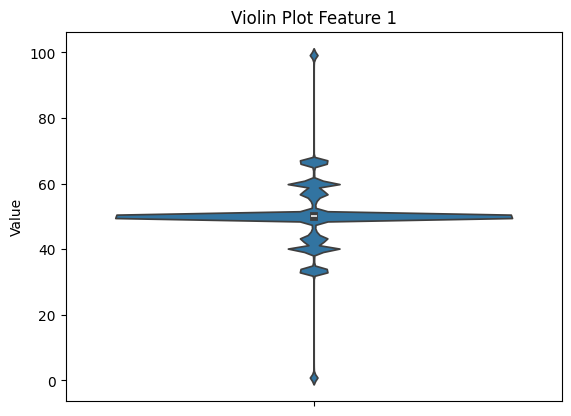

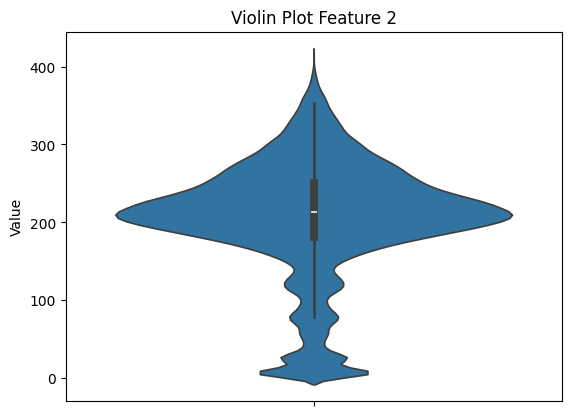

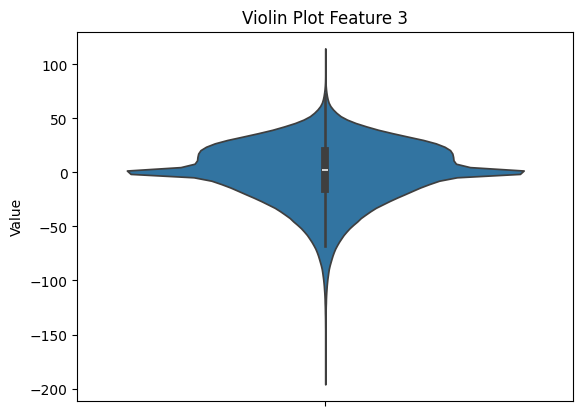

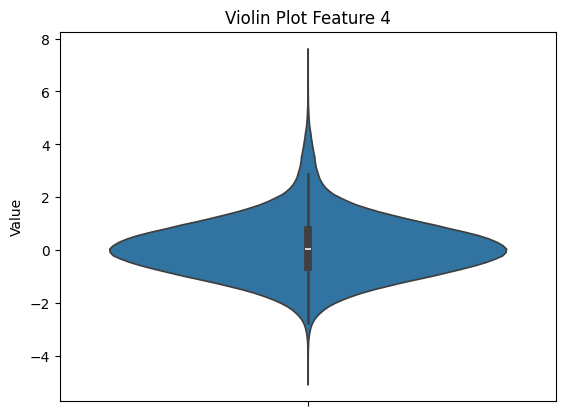

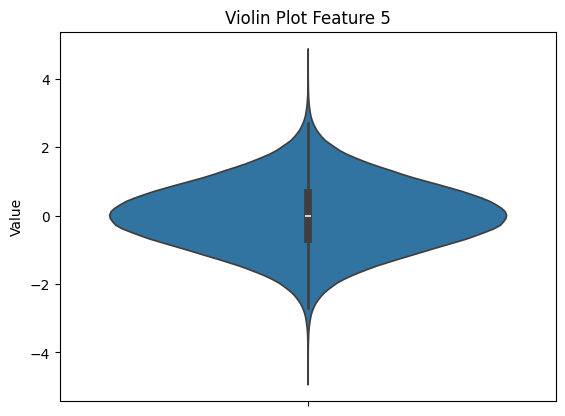

In [8]:
for i in range(X_train.shape[1]):
	generate_violin_plot(x=X_train[:,i], title=f"Feature {i+1}")

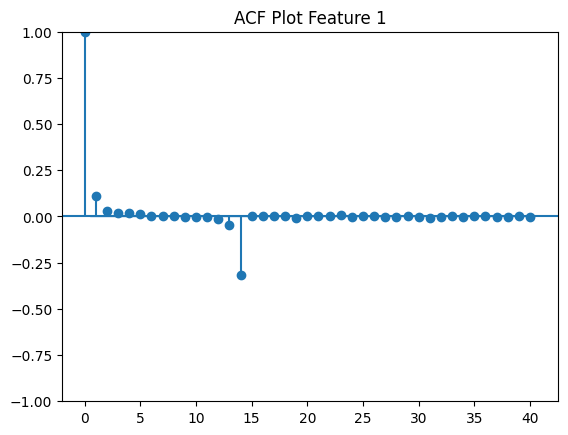

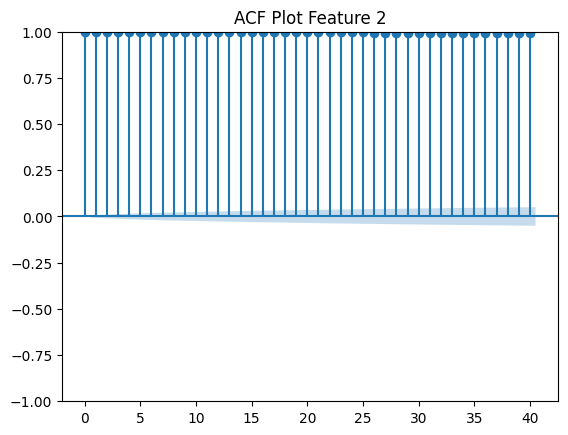

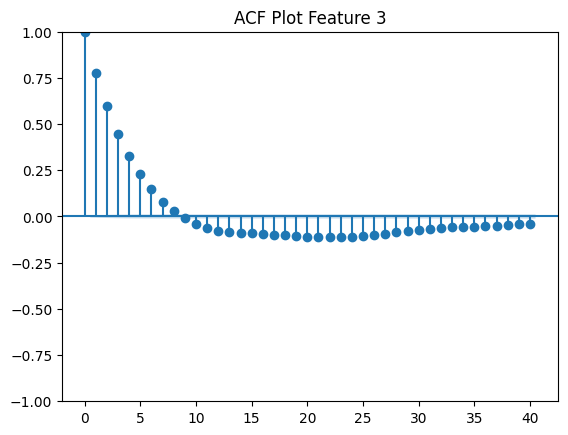

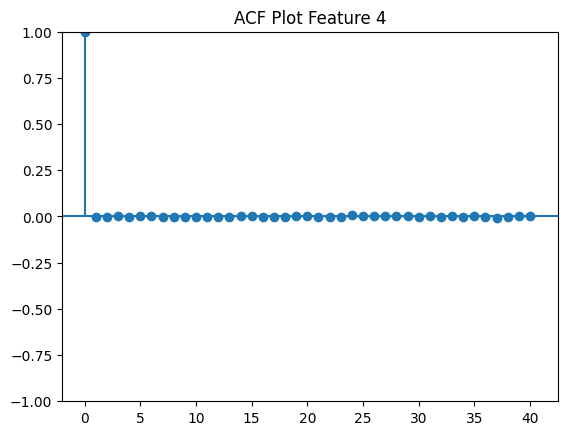

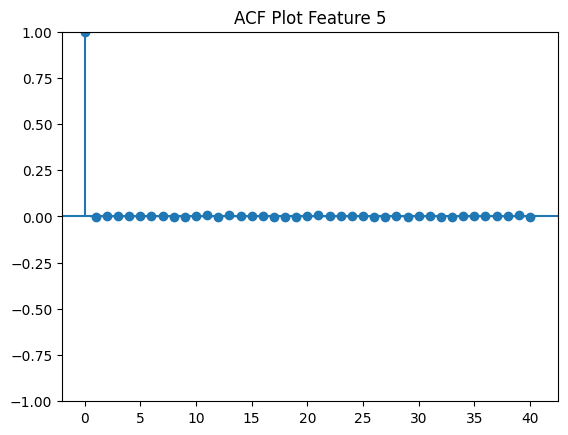

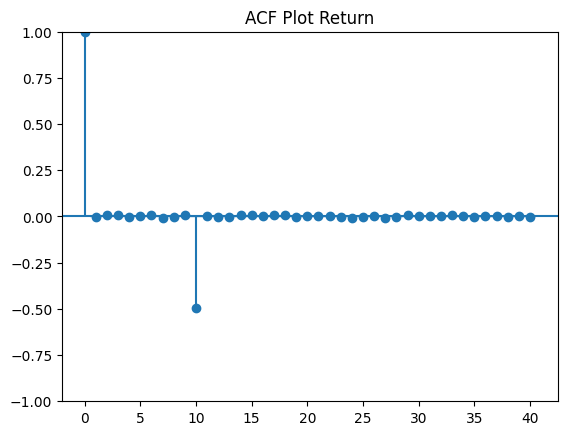

In [9]:
for i in range(X_train.shape[1]):
	generate_plot_acf(x=X_train[:,i], title=f"Feature {i+1}")
generate_plot_acf(x=y_train_reg, title="Return")

In [49]:
reg_pipeline_squared = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDRegressor(loss="squared_error"))
])

reg_pipeline_epsilon = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDRegressor(loss="epsilon_insensitive"))
])

reg_pipeline_huber = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDRegressor(loss="huber"))
])

In [50]:
cls_pipeline_squared = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDClassifier(loss="squared_error"))
])

cls_pipeline_epsilon = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDClassifier(loss="epsilon_insensitive"))
])

cls_pipeline_huber = Pipeline([
	('Imputation', KNNImputer()),
	('Scaler', StandardScaler()),
	('Model', SGDClassifier(loss="huber"))
])

In [51]:
kfold_cv(reg_pipeline_squared, X_train, y_train_reg)
kfold_cv(reg_pipeline_epsilon, X_train, y_train_reg)
kfold_cv(reg_pipeline_huber, X_train, y_train_reg)

Mean MSE (KFold) = 0.0047345575, Weigths (w) = [-0.0186442   0.00138084 -0.02073846 -0.00133825 -0.0013431 ], Bias (b) = [0.00278511]
Mean MSE (KFold) = 0.0052702129, Weigths (w) = [-0.01228408  0.00538721 -0.03852057 -0.00165827 -0.00532957], Bias (b) = [-0.01012119]
Mean MSE (KFold) = 0.0047645890, Weigths (w) = [-0.01455521  0.00185723 -0.0184003  -0.00033643  0.00072824], Bias (b) = [0.00304247]


In [52]:
kfold_cv(cls_pipeline_squared, X_train, y_train_class)
kfold_cv(cls_pipeline_epsilon, X_train, y_train_class)
kfold_cv(cls_pipeline_huber, X_train, y_train_class)

Mean MSE (KFold) = 0.3920005833, Weigths (w) = [[-0.15462016  0.01834366 -0.16804239  0.02049602 -0.02873241]], Bias (b) = [0.0062777]
Mean MSE (KFold) = 0.3837471716, Weigths (w) = [[-0.22517516  0.03776761 -0.46292825  0.05920009  0.03163935]], Bias (b) = [-0.18285821]
Mean MSE (KFold) = 0.3833696697, Weigths (w) = [[-0.18404329  0.04965582 -0.44375477  0.08644609 -0.00700468]], Bias (b) = [-0.20884823]


# Question 2

# Question 3

# Question 4

# Question 5